In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import seaborn as sns
from scipy.stats import poisson
import statsmodels.api as sm
import statsmodels.formula.api as smf
import itertools
from IPython.display import display, HTML

In [2]:
matches = pd.read_csv('data/matches/results.csv')
shootouts = pd.read_csv('data/matches/results.csv')
ranking = pd.read_csv('data/ranking/fifa_ranking-2021-05-27.csv')

We will procede with a simple poisson distribution for the score (home and away)

$P(x) = \frac{{e}^{-\lambda}{\lambda}^{x}}{x!}, \lambda > 0$


In [3]:
#exceptions = ['Comoros', 'Gambia']
#matches = matches.loc[matches.tournament.isin(['African Cup of Nations']) | matches.home_team.isin(exceptions) | matches.away_team.isin(exceptions), ]

In [4]:
matches = matches.loc[matches.date > '1993-01-01', ]

In [5]:
GAMES = len(matches)

home_rank = np.zeros(GAMES, dtype=np.int)
away_rank = np.zeros(GAMES, dtype=np.int)
home_total_points = np.zeros(GAMES, dtype=np.float)
away_total_points = np.zeros(GAMES, dtype=np.float)
for i in range(GAMES):
    home_listing = ranking[((ranking.country_full == matches.iloc[i].home_team) & 
                            (ranking.rank_date <= matches.iloc[i].date))].sort_values(by='rank_date', ascending=False)
    
    try:
        home_rank[i] = int(home_listing.iloc[0]['rank'])
    except:
        home_rank[i] = 155
        
    away_listing = ranking[((ranking.country_full == matches.iloc[i].away_team) & 
                            (ranking.rank_date <= matches.iloc[i].date))].sort_values(by='rank_date', ascending=False)
        
    try:
        away_rank[i] = int(away_listing.iloc[0]['rank'])
    except:
        away_rank[i] = 155

In [6]:
matches['home_rank'] = home_rank
matches['away_rank'] = away_rank

In [7]:
# create two dataframe for the home and away teams
home = matches[['home_team', 'home_rank', 'home_score']].rename(columns={'home_team':'team', 'home_rank':'rank', 'home_score':'score'})
away = matches[['away_team', 'away_rank', 'away_score']].rename(columns={'away_team':'team', 'away_rank':'rank', 'away_score':'score'})
# merge it into one
team_score = home.append(away).reset_index(drop=True)
# make an aggregation of the the score column group by the team
country_info = team_score.groupby('team')['score'].agg(['sum','count','mean']).reset_index()
country_info = country_info.rename(columns={'sum':'nb_goals', 'count':'nb_matches', 'mean':'goal_avg'})

del home, away

In [8]:
means = matches[['home_score','away_score']].mean()

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


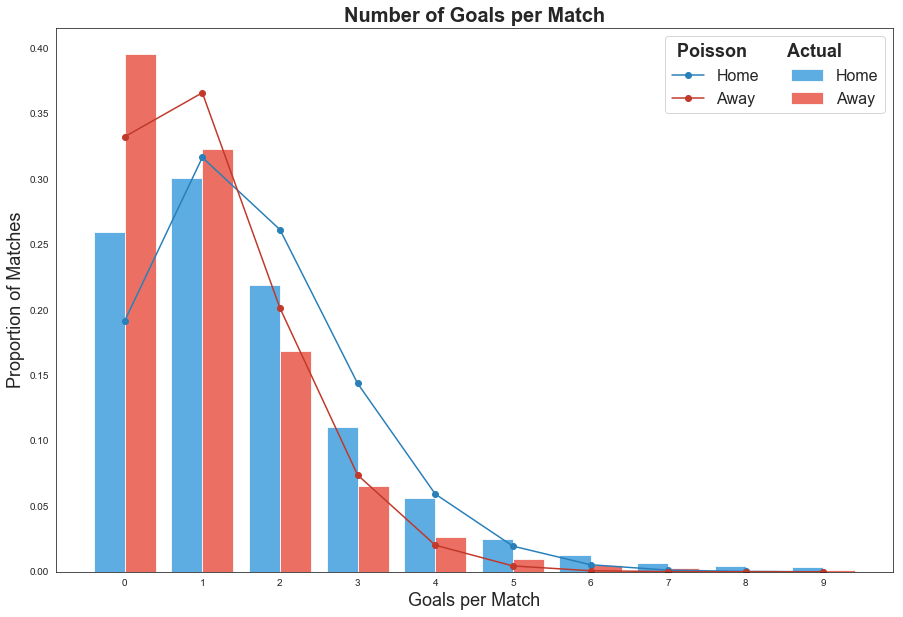

In [9]:
plt.figure(figsize=(15,10))
sns.set_style("white")
# construct Poisson  for each mean goals value
poisson_pred = np.column_stack([[poisson.pmf(k, means[j]) for k in range(10)] for j in range(2)])
# plot histogram of actual goals
plt.hist(matches[['home_score', 'away_score']].values, range(11), alpha=0.8,
         label=['Home', 'Away'],normed=True, color=["#3498db", "#e74c3c"])

# add lines for the Poisson distributions
pois1, = plt.plot([i-0.5 for i in range(1,11)], poisson_pred[:,0],
                  linestyle='-', marker='o',label="Home", color = '#2980b9')
pois2, = plt.plot([i-0.5 for i in range(1,11)], poisson_pred[:,1],
                  linestyle='-', marker='o',label="Away", color = '#c0392b')

leg=plt.legend(loc='upper right', fontsize=16, ncol=2)
leg.set_title("Poisson        Actual      ", prop = {'size':'18', 'weight':'bold'})

plt.xticks([i-0.5 for i in range(1,11)],[i for i in range(11)])
plt.xlabel("Goals per Match",size=18)
plt.ylabel("Proportion of Matches",size=18)
plt.title("Number of Goals per Match",size=20,fontweight='bold')
plt.show()


C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


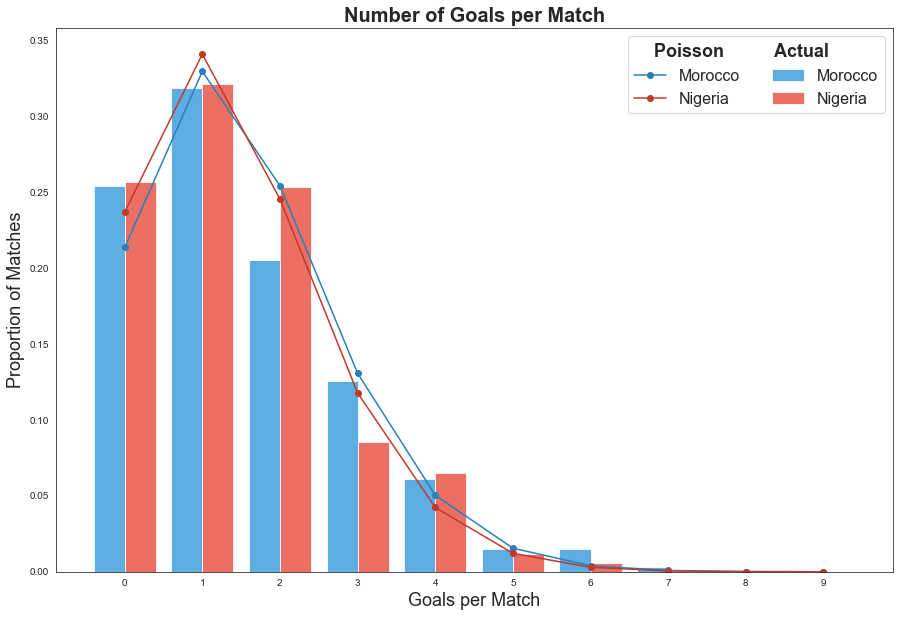

In [10]:
plt.figure(figsize=(15,10))
sns.set_style("white")
team1, team2 = "Morocco", "Nigeria"
matches_t1 = team_score[team_score['team'] == team1]
matches_t2 = team_score[team_score['team'] == team2]
    
mean_t1 = matches_t1['score'].mean()
mean_t2 = matches_t2['score'].mean()

# construct Poisson  for each mean goals value
poisson_pred_t1 = [poisson.pmf(k, mean_t1) for k in range(10)]
poisson_pred_t2 = [poisson.pmf(k, mean_t2) for k in range(10)]

# plot histogram of actual goals
plt.hist([matches_t1['score'].values, matches_t2['score'].values], range(11), alpha=0.8,
         label=[team1, team2],normed=True, color=["#3498db", "#e74c3c"])

# add lines for the Poisson distributions
pois1, = plt.plot([i-0.5 for i in range(1,11)], poisson_pred_t1,
                  linestyle='-', marker='o',label=team1, color = '#2980b9')
pois2, = plt.plot([i-0.5 for i in range(1,11)], poisson_pred_t2,
                  linestyle='-', marker='o',label=team2, color = '#c0392b')

leg=plt.legend(loc='upper right', fontsize=16, ncol=2)
leg.set_title("Poisson          Actual      ", prop = {'size':'18', 'weight':'bold'})

plt.xticks([i-0.5 for i in range(1,11)],[i for i in range(11)])
plt.xlabel("Goals per Match",size=18)
plt.ylabel("Proportion of Matches",size=18)
plt.title("Number of Goals per Match",size=20,fontweight='bold')
plt.show()

In [11]:
matches = matches.astype({'date':'datetime64[ns]'}).dropna()

def weight_from_tournament(tournament):
    if 'Cup' in tournament or 'Euro' in tournament:
        return 1
    else :
        return 100

# Create weight column based on the date
matches.loc[:,'weight'] = matches['tournament'].apply(weight_from_tournament)
matches.loc[:,'weight'] = 1 / ((2022 - matches['date'].dt.year.astype('int64'))*matches['weight'])

# Create model data
matches_model_data = pd.concat([matches[['home_team','away_team','home_score','weight', 'home_rank', 'away_rank']].rename(
            columns={'home_team':'team', 'away_team':'opponent','home_score':'goals', 'home_rank':'team_rank', 'away_rank':'opponent_rank'}),
           matches[['away_team','home_team','away_score','weight', 'home_rank', 'away_rank']].rename(
            columns={'away_team':'team', 'home_team':'opponent','away_score':'goals', 'home_rank':'team_rank', 'away_rank':'opponent_rank'})])

In [12]:
poisson_model = smf.glm(formula="goals ~ team + opponent + team_rank + opponent_rank", data=matches_model_data, 
                        family=sm.families.Poisson(), freq_weights=matches_model_data['weight'].values).fit()

In [13]:
def get_proba_match(foot_model, team1, team2, max_goals=10):
    # Get team ranks
    try:
        team1_rank = ranking[((ranking.rank_date == '2021-05-27') & (ranking.country_full == h_country))]['rank'].values[0]
    except:
        team1_rank = 155
        
    try:
        team2_rank = ranking[((ranking.rank_date == '2021-05-27') & (ranking.country_full == a_country))]['rank'].values[0]
    except:
        team2_rank = 155
        
    # Get the average goal for each team
    t1_goals_avg = foot_model.predict(pd.DataFrame(data={'team': team1, 'opponent': team2, 'team_rank': team1_rank, 'opponent_rank': team2_rank}, index=[1])).values[0]
    t2_goals_avg = foot_model.predict(pd.DataFrame(data={'team': team2, 'opponent': team1, 'team_rank': team2_rank, 'opponent_rank': team1_rank}, index=[1])).values[0]
    
    # Get probability of all possible score for each team
    team_pred = [[poisson.pmf(i, team_avg) for i in range(0, max_goals+1)] for team_avg in [t1_goals_avg, t2_goals_avg]]
    
    # Do the product of the 2 vectors to get the matrix of the match
    match = np.outer(np.array(team_pred[0]), np.array(team_pred[1]))
    
    # Get the proba for each possible outcome
    t1_wins = np.sum(np.tril(match, -1))
    draw = np.sum(np.diag(match))
    t2_wins = np.sum(np.triu(match, 1))
    result_proba = [t1_wins, draw, t2_wins]
    
    # Adjust the proba to sum to one
    result_proba =  np.array(result_proba)/ np.array(result_proba).sum(axis=0,keepdims=1)
    team_pred[0] = np.array(team_pred[0])/np.array(team_pred[0]).sum(axis=0,keepdims=1)
    team_pred[1] = np.array(team_pred[1])/np.array(team_pred[1]).sum(axis=0,keepdims=1)
    return result_proba, [np.array(team_pred[0]), np.array(team_pred[1])]

In [14]:
import uuid
all_games = {}

In [15]:
def get_match_result(foot_model, team1, team2, elimination=False, max_draw=50, max_goals=10):
    # Get the proba
    proba, score_proba = get_proba_match(foot_model, team1, team2, max_goals)
    
    # Get the result, if it's an elimination game we have to be sure the result is not draw
    results = pd.Series([np.random.choice([team1, 'draw', team2], p=proba) for i in range(0,max_draw)]).value_counts()
    result = results.index[0] if not elimination or (elimination and results.index[0] != 'draw') else results.index[1]
    
    # If the result is not a draw game then we calculate the score of the winner from 1 to the max_goals 
    # and the score of the looser from 0 to the score of the winner
    if (result != 'draw'): 
        i_win, i_loose = (0,1) if result == team1 else (1,0)
        score_proba[i_win] = score_proba[i_win][1:]/score_proba[i_win][1:].sum(axis=0,keepdims=1)
        winner_score = pd.Series([np.random.choice(range(1, max_goals+1), p=score_proba[i_win]) for i in range(0,max_draw)]).value_counts().index[0]
        score_proba[i_loose] = score_proba[i_loose][:winner_score]/score_proba[i_loose][:winner_score].sum(axis=0,keepdims=1)
        looser_score = pd.Series([np.random.choice(range(0, winner_score), p=score_proba[i_loose]) for i in range(0,max_draw)]).value_counts().index[0]
        score = [winner_score, looser_score]
    # If it's a draw then we calculate a score and repeat it twice
    else:
        score = np.repeat(pd.Series([np.random.choice(range(0, max_goals+1), p=score_proba[0]) for i in range(0,max_draw)]).value_counts().index[0],2)
    looser = team2 if result == team1 else team1 if result != 'draw' else 'draw'
    
    all_games[uuid.uuid4()] = {'team' : team1, 'opponent' : team2, 'goals_team':score[0] if team1==result else score[1], 'goals_opponent':score[1] if team1==result else score[0]}
    return result, looser, score

In [16]:
groupA = ['Burkina Faso', 'Cape Verde', 'Cameroon', 'Ethiopia']
groupB = ['Guinea', 'Malawi', 'Senegal', 'Zimbabwe']
groupC = ['Comoros', 'Gabon', 'Ghana', 'Morocco']
groupD = ['Egypt', 'Guinea-Bissau', 'Nigeria', 'Sudan']
groupE = ['Algeria', 'Ivory Coast', 'Equatorial Guinea', 'Sierra Leone']
groupF = ['Gambia', 'Mali', 'Mauritania', 'Tunisia']
groups = [groupA, groupB, groupC, groupD, groupE, groupF]
groups_names = ['A', 'B', 'C', 'D', 'E', 'F']

In [17]:
round_16 = pd.read_csv('data/round_16/round_16.csv', sep=';')
round_16_possibilities = pd.read_csv('data/round_16/round_16_possibilities.csv', sep=';')

In [18]:
def get_group_result(foot_model, group):
    ranking = pd.DataFrame({'points':[0,0,0,0], 'diff':[0,0,0,0], 'goals':[0,0,0,0]}, index=group)
    for team1, team2 in itertools.combinations(group, 2):
        result, looser, score = get_match_result(foot_model, team1, team2)
        #print(result, '-', looser,':', score)
        if result == 'draw':
            ranking.loc[[team1, team2], 'points'] += 1
            ranking.loc[[team1, team2], 'goals'] += score[0]
        else:
            ranking.loc[result, 'points'] += 3
            ranking.loc[result, 'goals'] += score[0]
            ranking.loc[looser, 'goals'] += score[1]
            ranking.loc[result, 'diff'] += score[0]-score[1]
            ranking.loc[looser, 'diff'] -= score[0]-score[1]
            
    return ranking.sort_values(by=['points','diff','goals'], ascending=False)

def get_team(code, gr, r16p):
    if len(code)==2:
        return gr.loc[code]['name']
    else:
        return gr.loc[r16p.iloc[0][code]]['name']

def get_final_result(foot_model, groups_result, r16=round_16, r16p=round_16_possibilities):
    round_of_16 = []
    quarter_finals = []
    semi_finals = []
    
    
    # SIMULATE ROUND OF 16
    for i in range(0, 8):
        round_of_16.append(get_match_result(foot_model, 
                                            get_team(r16.iloc[i]['home_team'], groups_result, r16p), 
                                            get_team(r16.iloc[i]['away_team'], groups_result, r16p), 
                                            elimination=True))
    
    
    # SIMULATE QUATER FINALS
    quarter_finals.append(get_match_result(foot_model, round_of_16[0][0], round_of_16[2][0], elimination=True))
    quarter_finals.append(get_match_result(foot_model, round_of_16[1][0], round_of_16[3][0], elimination=True))
    quarter_finals.append(get_match_result(foot_model, round_of_16[4][0], round_of_16[6][0], elimination=True))
    quarter_finals.append(get_match_result(foot_model, round_of_16[5][0], round_of_16[7][0], elimination=True))
    
    # SIMULATE SEMI FINALS
    semi_finals.append(get_match_result(foot_model, quarter_finals[0][0], quarter_finals[2][0], elimination=True))
    semi_finals.append(get_match_result(foot_model, quarter_finals[1][0], quarter_finals[3][0], elimination=True))
    
    # SIMULATE 3RD PLACE MATCH
    little_final = get_match_result(foot_model, semi_finals[0][1], semi_finals[1][1], elimination=True)
    
    # SIMULATE FINAL
    final = get_match_result(foot_model, semi_finals[0][0], semi_finals[1][0], elimination=True)
    
    return round_of_16, quarter_finals, semi_finals, little_final, final

In [19]:
#Needed for our african CUP
groupe_stage = {}
for i in range(0, 6):
    r = get_group_result(poisson_model, groups[i])
    for k in range(1, 5):
        groupe_stage[groups_names[i]+str(k)] = {'group' : groups_names[i],
                                                'name' : r.index[k-1], 
                                                'points' : r.iloc[k-1]['points'], 
                                                'goals_difference' : r.iloc[k-1]['goals'], 
                                                'goals_scored' : r.iloc[k-1]['goals'], 
                                                'rank' : k}

combination = ''.join(list(pd.DataFrame.from_dict(groupe_stage, orient='index').query('rank==3')\
                           .sort_values(by=['points', 'goals_difference', 'goals_scored'], ascending=False).group[0:4].sort_values()))

groups_ranking = pd.DataFrame.from_dict(groupe_stage, orient='index')

In [20]:
round_of_16, quarter_finals, semi_finals, little_final, final = get_final_result(poisson_model, 
                                                                                 groups_ranking, 
                                                                                 round_16, 
                                                                                 round_16_possibilities.query('combination=="{0}"'.format(combination)))

In [21]:
#pd.DataFrame.from_dict(all_games, orient='index')
#all_games

In [22]:
groups_rankings, round_of_16s, quarter_finalss, semi_finalss, little_finals, finals = [], [], [], [], [], []

for exp in range(0, 10):
    groupe_stage = {}
    for i in range(0, 6):
        r = get_group_result(poisson_model, groups[i])
        for k in range(1, 5):
            groupe_stage[groups_names[i]+str(k)] = {'group' : groups_names[i],
                                                    'name' : r.index[k-1], 
                                                    'points' : r.iloc[k-1]['points'], 
                                                    'goals_difference' : r.iloc[k-1]['goals'], 
                                                    'goals_scored' : r.iloc[k-1]['goals'], 
                                                    'rank' : k}

    combination = ''.join(list(pd.DataFrame.from_dict(groupe_stage, orient='index').query('rank==3')\
                               .sort_values(by=['points', 'goals_difference', 'goals_scored'], ascending=False).group[0:4].sort_values()))

    groups_ranking = pd.DataFrame.from_dict(groupe_stage, orient='index')
    groups_ranking['try'] = 'try_' + str(exp)
    groups_rankings.append(groups_ranking)
    
    round_of_16, quarter_finals, semi_finals, little_final, final = get_final_result(poisson_model, 
                                                                                 groups_ranking, 
                                                                                 round_16, 
                                                                                 round_16_possibilities.query('combination=="{0}"'.format(combination)))
    
    d16 = pd.DataFrame(round_of_16, columns=['winner', 'loser', 'score'])
    d16['step'] = 'round_of_16'
    d16['step_'] = 16
    d16['try'] = 'try_' + str(exp)
    round_of_16s.append(d16)
    
    d8 = pd.DataFrame(quarter_finals, columns=['winner', 'loser', 'score'])
    d8['step'] = 'quarter_finals'
    d8['step_'] = 8
    d8['try'] = 'try_' + str(exp)
    quarter_finalss.append(d8)
    
    d4 = pd.DataFrame(semi_finals, columns=['winner', 'loser', 'score'])
    d4['step'] = 'semi_finals'
    d4['step_'] = 4
    d4['try'] = 'try_' + str(exp)
    semi_finalss.append(d4)

    d2 = pd.DataFrame(np.reshape(little_final, (1, 3)), columns=['winner', 'loser', 'score'])
    d2['step'] = 'little_final'
    d2['step_'] = 2
    d2['try'] = 'try_' + str(exp)
    little_finals.append(d2)
    
    d1 = pd.DataFrame(np.reshape(final, (1, 3)), columns=['winner', 'loser', 'score'])
    d1['step'] = 'final'
    d1['step_'] = 1
    d1['try'] = 'try_' + str(exp)
    finals.append(d1)

In [23]:
df = pd.concat(round_of_16s + quarter_finalss + semi_finalss + little_finals + finals)

In [24]:
winners = df.groupby(['step', 'step_', 'winner']).agg({'try':'count'}).reset_index().sort_values(by='step')
winners['status'] = 'win'
winners.columns = ['step', 'step_', 'country', 'try', 'status']

In [25]:
loosers = df.groupby(['step', 'step_', 'loser']).agg({'try':'count'}).reset_index().sort_values(by='step')
loosers['status'] = 'lose'
loosers.columns = ['step', 'step_', 'country', 'try', 'status']

In [26]:
tries = pd.concat([winners, loosers])

In [27]:
previous = None
for step in ['round_of_16', 'quarter_finals', 'semi_finals', 'little_final', 'final', 'win']:
    if step != 'win':
        kfka = tries.query('step=="{0}"'.format(step)).groupby('country').agg({'try':'sum'}).reset_index()
        kfka['probability_{0}'.format(step)] = kfka['try']/10

        if step == 'round_of_16':
            previous = kfka
        else:
            previous = kfka.merge(previous, how='outer', left_on='country', right_on='country')
    else:
        kfka = tries.query('step=="final" and status=="win"').groupby('country').agg({'try':'sum'}).reset_index()
        kfka['probability_{0}'.format(step)] = kfka['try']/10
        
        previous = kfka.merge(previous, how='outer', left_on='country', right_on='country')

In [28]:
previous.fillna(0)[['country'] + ['probability_'+col for col in ['round_of_16', 'quarter_finals', 'semi_finals', 'little_final', 'final', 'win']]]\
.sort_values(by=['probability_'+col for col in ['win', 'final', 'little_final', 'semi_finals', 'quarter_finals', 'round_of_16']], ascending=False)

,country,probability_round_of_16,probability_quarter_finals,probability_semi_finals,probability_little_final,probability_final,probability_win
0,Morocco,1.0,1.0,1.0,0.0,1.0,1.0
6,Senegal,1.0,1.0,0.5,0.3,0.2,0.0
2,Egypt,1.0,0.9,0.5,0.3,0.2,0.0
5,Nigeria,1.0,0.6,0.4,0.2,0.2,0.0
3,Ghana,1.0,1.0,0.5,0.4,0.1,0.0
7,Tunisia,1.0,0.8,0.2,0.1,0.1,0.0
1,Algeria,1.0,0.5,0.2,0.1,0.1,0.0
4,Mali,1.0,0.4,0.1,0.0,0.1,0.0
8,Ivory Coast,1.0,0.8,0.6,0.6,0.0,0.0
9,Cameroon,1.0,1.0,0.0,0.0,0.0,0.0


In [29]:
grk = pd.concat(groups_rankings)

In [30]:
grk.groupby(['group', 'name']).agg({'points':'mean', 'goals_difference':'mean','goals_scored':'mean','rank':['min','mean','max']})\
.sort_values(by=['group', ('points','mean')], ascending=[True, False])

points goals_difference goals_scored rank         
                          mean             mean         mean  min mean max
group name                                                                
A     Cameroon             8.6              3.5          3.5    1  1.0   1
      Cape Verde           4.6              1.7          1.7    2  2.6   3
      Burkina Faso         4.3              1.6          1.6    2  2.4   3
      Ethiopia             0.0              0.1          0.1    4  4.0   4
B     Senegal              9.0              3.5          3.5    1  1.0   1
      Guinea               5.5              2.0          2.0    2  2.1   3
      Zimbabwe             2.6              0.9          0.9    2  3.1   4
      Malawi               0.6              0.3          0.3    3  3.8   4
C     Morocco              9.0              5.3          5.3    1  1.0   1
      Ghana                6.0              3.8          3.8    2  2.0   2
      Gabon                3.0              2.3          2.3    3  3.0   3
      Comoros              0.0              0.0          0.0    4  4.0   4
D     Egypt                8.1              4.0          4.0    1  1.3   2
      Nigeria              6.9              3.1          3.1    1  1.7   2
      Guinea-Bissau        2.8              1.1          1.1    3  3.0   3
      Sudan                0.1              0.2          0.2    4  4.0   4
E     Algeria              7.6              3.2          3.2    1  1.4   2
      Ivory Coast          7.3              3.2          3.2    1  1.6   2
      Equatorial Guinea    2.4              0.8          0.8    3  3.0   3
      Sierra Leone         0.3              0.1          0.1    4  4.0   4
F     Mali                 7.7              3.0          3.0    1  1.3   2
      Tunisia              7.1              2.8          2.8    1  1.7   2
      Gambia               2.6              1.0          1.0    3  3.0   3
      Mauritania           0.2              0.2          0.2    4  4.0   4